# School Shooting EDA

In [283]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import TimeSeriesSplit
plt.style.use('dark_background')

from fbprophet import Prophet

In [2]:
#!pip install pystan==2.17.1.0 and fbprophet

In [3]:
school_df = pd.read_csv('data/school_shootings/cps_01_formatted.csv', sep = ',')
#gives census data based on type of school, N = Nursey, K = Kindergarten, E = Elementary, H = High school, C = College

In [4]:
school_df.head()

,Year,Total enrolled,N-Total,N-Public,N-Private,K-Total,K-Public,K-Private,E-Total,E-Public,E-Private,H-Total,H-Public,H-Private,C-Total,C-Public,C-Private,C-Full time
0,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018,76840.0,4836.0,2763.0,2073.0,3908.0,3529.0,379.0,32483.0,29665.0,2818.0,16706.0,15519.0,1187.0,18908.0,15234.0,3674.0,14204.0
3,2017,76409.0,4676.0,2782.0,1894.0,3964.0,3542.0,422.0,32530.0,29873.0,2656.0,16841.0,15546.0,1295.0,18398.0,14806.0,3592.0,13606.0
4,2016,77232.0,4746.0,2806.0,1941.0,4017.0,3654.0,364.0,32604.0,29978.0,2627.0,16668.0,15330.0,1338.0,19196.0,14971.0,4225.0,14421.0


In [5]:
shooting_df = pd.read_csv('data/school_shootings/pah_wikp_combo.csv', sep = ',')

In [6]:
shooting_df.head()

,Date,City,State,AreaType,School,Fatalities,Wounded,Dupe,Source,Desc
0,3/27/90,Brooklyn,New York,NaN,C,0,1.0,NaN,Wikp,A black youth was taunted with racial slurs by...
1,5/20/90,Centerville,Tennessee,suburban,HS,1,NaN,NaN,Pah,NaN
2,8/26/90,Las Vegas,Nevada,urban,HS,1,NaN,NaN,Pah,NaN
3,9/11/90,San Antonio,Texas,NaN,HS,0,3.0,NaN,Wikp,3 students were wounded when gunfire broke out...
4,1/8/91,Richardson,Texas,urban,HS,0,NaN,NaN,Pah,NaN


In [7]:
shooting_df.shape

(695, 10)

In [8]:
ownership = pd.read_csv('data/TL-354-State-Level Estimates of Household Firearm Ownership.csv', sep = ',')

In [9]:
ownership.head()

,FIP,Year,STATE,HFR,HFR_se,universl,permit,Fem_FS_S,Male_FS_S,BRFSS,GALLUP,GSS,PEW,HuntLic,GunsAmmo,BackChk,PewQChng,BS1,BS2,BS3
0,1,1980,Alabama,0.608,0.031,0,0,0.824324,0.833795,-9.0,0.55395,0.583632,-9.0,0.291102,-0.509164,-9.0,0,0.0,0.0,0.0
1,1,1981,Alabama,0.597,0.047,0,0,0.692308,0.831126,-9.0,-9.00000,-9.000000,-9.0,0.294962,-0.618954,-9.0,0,1.0,0.0,0.0
2,1,1982,Alabama,0.661,0.036,0,0,0.771739,0.821429,-9.0,-9.00000,0.655196,-9.0,0.290545,-0.526692,-9.0,0,2.0,0.0,0.0
3,1,1983,Alabama,0.586,0.038,0,0,0.688172,0.819277,-9.0,0.61144,-9.000000,-9.0,0.284983,-0.713227,-9.0,0,3.0,0.0,0.0
4,1,1984,Alabama,0.624,0.036,0,0,0.710000,0.775956,-9.0,-9.00000,0.626933,-9.0,0.281622,-0.733305,-9.0,0,4.0,0.0,0.0


In [10]:
ownership.shape

(1850, 20)

In [11]:
gun_laws = pd.read_csv('data/gun_laws/raw_data.csv')

In [12]:
gun_laws.tail()

,state,year,age18longgunpossess,age18longgunsale,age21handgunpossess,age21handgunsale,age21longgunpossess,age21longgunsale,age21longgunsaled,alcoholism,...,universal,universalh,universalpermit,universalpermith,violent,violenth,violentpartial,waiting,waitingh,lawtotal
1345,Virginia,2017,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,13
1346,Washington,2017,1,0,0,0,0,0,0,0,...,1,1,1,1,0,0,0,0,0,43
1347,West Virginia,2017,0,1,0,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,21
1348,Wisconsin,2017,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,23
1349,Wyoming,2017,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9


In [13]:
#gun_laws.isnull().sum()

In [14]:
gun_laws.shape

(1350, 136)

In [15]:
gun_provisions = pd.read_excel('data/gun_laws/codebook.xlsx')

In [16]:
gun_provisions.head()

,Category Code,Category,Sub-Category,Variable Name,Brief Description of Provision,Detailed Description of Provision,Coding Notes,Coding Instructions,Notes,Data Source and Attribution
0,1,Dealer regulations,Licensing,dealer,State dealer license required for sale of all ...,All firearm dealers are required to have a sta...,State requires all persons engaged in the busi...,If all firearm dealers are required to have a ...,NaN,"Coded by Michael Siegel, MD, MPH, Boston Unive..."
1,1,Dealer regulations,Licensing,dealerh,State dealer license required for sale of hand...,All firearm dealers that sell handguns are req...,State requires all persons engaged in the busi...,If only dealers of handguns or handguns AND as...,NaN,"Coded by Michael Siegel, MD, MPH, Boston Unive..."
2,1,Dealer regulations,Recordkeeping,recordsdealer,Licensed dealers are required to keep and reta...,Licensed dealers are required to keep and reta...,Recordkeeping refers to the recording of sales...,If record keeping and retention is required on...,Federal law requires licensed dealers to keep ...,"Coded by Michael Siegel, MD, MPH, Boston Unive..."
3,1,Dealer regulations,Recordkeeping,recordsdealerh,Licensed dealers are required to keep and reta...,Licensed dealers are required to keep and reta...,Recordkeeping refers to the recording of sales...,If record keeping and retention is required on...,Federal law requires licensed dealers to keep ...,"Coded by Michael Siegel, MD, MPH, Boston Unive..."
4,1,Dealer regulations,Recordkeeping,recordsall,All private sellers and licensed dealers are r...,Both private sellers and licensed dealers are ...,Recordkeeping refers to the recording of sales...,If all private sellers and licensed dealers ar...,Federal law requires licensed dealers to keep ...,"Coded by Michael Siegel, MD, MPH, Boston Unive..."


In [17]:
state_guns = pd.read_csv(r'data/raw-thoughtco-guns-by-state.txt', delimiter = '\t')

In [18]:
state_guns.head()

,Rank,State,# of guns per capita,# of guns registered
0,1,Wyoming,229.24,"132,806"
1,2,Washington D.C.,68.05,"47,228"
2,3,New Hampshire,46.76,"64,135"
3,4,New Mexico,46.73,"97,580"
4,5,Virginia,36.34,"307,822"


In [19]:
state_guns.isnull().sum()

Rank                    0
State                   0
# of guns per capita    0
# of guns registered    0
dtype: int64

In [20]:
shooting_df

,Date,City,State,AreaType,School,Fatalities,Wounded,Dupe,Source,Desc
0,3/27/90,Brooklyn,New York,NaN,C,0,1.0,NaN,Wikp,A black youth was taunted with racial slurs by...
1,5/20/90,Centerville,Tennessee,suburban,HS,1,NaN,NaN,Pah,NaN
2,8/26/90,Las Vegas,Nevada,urban,HS,1,NaN,NaN,Pah,NaN
3,9/11/90,San Antonio,Texas,NaN,HS,0,3.0,NaN,Wikp,3 students were wounded when gunfire broke out...
4,1/8/91,Richardson,Texas,urban,HS,0,NaN,NaN,Pah,NaN
...,...,...,...,...,...,...,...,...,...,...
690,1/14/20,Bellaire,Texas,NaN,HS,1,0.0,NaN,Wikp,A 19-year old student was shot in the chest an...
691,1/14/20,Fort Worth,Texas,NaN,HS,0,2.0,NaN,Wikp,An adult male and a 10-year old child were inj...
692,1/23/20,Oxnard,California,NaN,ES,0,1.0,NaN,Wikp,NaN
693,2/3/20,Commerce,Texas,NaN,C,2,1.0,NaN,Wikp,"Jacques Dshawn Smith, 21, gained access to Pri..."


In [21]:
shooting_df.loc[shooting_df['Fatalities'] == max(shooting_df['Fatalities'])]
# df.loc[df['column_name'] == some_value]

,Date,City,State,AreaType,School,Fatalities,Wounded,Dupe,Source,Desc
342,4/16/07,Blacksburg,Virginia,NaN,C,33,23.0,NaN,Wikp,"Virginia Tech shooting: 23-year-old student,¬†..."


In [22]:
shooting_df['Desc'][342]

'Virginia Tech shooting: 23-year-old student,¬†Seung-Hui Cho, killed thirty-two students and faculty members at¬†Virginia Tech, and wounded another seventeen students and faculty members in two separate attacks before committing suicide. The incident is the third-deadliest mass shooting by a single gunman in modern U.S. history.'

In [23]:
shooting_df.loc[shooting_df['State'] == 'Colorado']

,Date,City,State,AreaType,School,Fatalities,Wounded,Dupe,Source,Desc
199,4/20/99,Littleton,Colorado,suburban,HS,15,NaN,True,Pah,NaN
200,4/20/99,Littleton,Colorado,NaN,HS,15,21.0,NaN,Wikp,Columbine High School massacre: 18-year-old¬†E...
320,9/27/06,Bailey,Colorado,suburban,HS,1,NaN,True,Pah,NaN
321,9/27/06,Bailey,Colorado,NaN,HS,2,0.0,NaN,Wikp,Platte Canyon High School hostage crisis: 53-y...
437,2/23/10,Littleton,Colorado,suburban,MS,0,NaN,True,Pah,NaN
438,2/23/10,Littleton,Colorado,NaN,MS,0,2.0,NaN,Wikp,"At¬†Deer Creek Middle School, 32-year-old Bruc..."
459,12/6/10,Aurora,Colorado,NaN,HS,0,1.0,NaN,Wikp,In a gang-related attack outside¬†Aurora Centr...
558,12/13/13,Centennial,Colorado,suburban,HS,2,NaN,True,Pah,NaN
559,12/13/13,Centennial,Colorado,NaN,HS,2,0.0,NaN,Wikp,"18-year-old Karl Pierson, shot 17-year-old stu..."
678,5/7/19,Highlands Ranch,Colorado,NaN,HS,1,7.0,NaN,Wikp,STEM School Highlands Ranch shooting: Two shoo...


In [24]:
shooting_df.shape

(695, 10)

## Mapping

In [25]:
import plotly.express as px
import plotly.figure_factory as ff
import folium
from geopy.geocoders import Nominatim
import plotly.graph_objects as go

In [26]:
#!pip install folium

In [27]:
#!pip install arcgis

In [28]:
#!pip install plotly

In [29]:
#!pip install geopy

In [30]:
geolocator = Nominatim(user_agent = 'myapplication')
loc = geolocator.geocode('Denver Colorado')
print(loc.raw['lat'],',', loc.raw['lon'])

39.7392364 , -104.9848623


In [31]:
geoloc = Nominatim(user_agent = 'myapplication')
locat = geoloc.geocode('Blountville Tennessee')
print(locat.latitude, locat.longitude)

36.533767 -82.33343531171823


In [32]:
shooting_df['Latitude'] = np.nan
shooting_df['Longitude'] = np.nan

In [33]:
shooting_df.head()

,Date,City,State,AreaType,School,Fatalities,Wounded,Dupe,Source,Desc,Latitude,Longitude
0,3/27/90,Brooklyn,New York,NaN,C,0,1.0,NaN,Wikp,A black youth was taunted with racial slurs by...,NaN,NaN
1,5/20/90,Centerville,Tennessee,suburban,HS,1,NaN,NaN,Pah,NaN,NaN,NaN
2,8/26/90,Las Vegas,Nevada,urban,HS,1,NaN,NaN,Pah,NaN,NaN,NaN
3,9/11/90,San Antonio,Texas,NaN,HS,0,3.0,NaN,Wikp,3 students were wounded when gunfire broke out...,NaN,NaN
4,1/8/91,Richardson,Texas,urban,HS,0,NaN,NaN,Pah,NaN,NaN,NaN


In [34]:
shooting_df = shooting_df.replace({'Carollton':'Carrollton', 'Gundy':'Grundy','Nobelsville':'Noblesville', 'IA': 'Iowa', 'D.C.': 'District Of Columbia'})

In [35]:
shooting_df.loc[(shooting_df.City == 'Blountville') & (shooting_df.State == 'Alabama'), 'City'] = 'Blountsville'

In [36]:
shooting_df.loc[shooting_df['City'] == 'Blountsville']

,Date,City,State,AreaType,School,Fatalities,Wounded,Dupe,Source,Desc,Latitude,Longitude
672,3/22/19,Blountsville,Alabama,NaN,ES,0,1.0,NaN,Wikp,A substitute teacher at Blountsville Elementar...,NaN,NaN


In [37]:
shooting_df.loc[shooting_df['City'] == 'Blountville']

,Date,City,State,AreaType,School,Fatalities,Wounded,Dupe,Source,Desc,Latitude,Longitude
444,8/31/10,Blountville,Tennessee,suburban,HS,1,NaN,NaN,Pah,NaN,NaN,NaN


In [38]:
shooting_df.head(10)

,Date,City,State,AreaType,School,Fatalities,Wounded,Dupe,Source,Desc,Latitude,Longitude
0,3/27/90,Brooklyn,New York,NaN,C,0,1.0,NaN,Wikp,A black youth was taunted with racial slurs by...,NaN,NaN
1,5/20/90,Centerville,Tennessee,suburban,HS,1,NaN,NaN,Pah,NaN,NaN,NaN
2,8/26/90,Las Vegas,Nevada,urban,HS,1,NaN,NaN,Pah,NaN,NaN,NaN
3,9/11/90,San Antonio,Texas,NaN,HS,0,3.0,NaN,Wikp,3 students were wounded when gunfire broke out...,NaN,NaN
4,1/8/91,Richardson,Texas,urban,HS,0,NaN,NaN,Pah,NaN,NaN,NaN
5,2/6/91,Donna,Texas,NaN,HS,1,0.0,NaN,Wikp,15-year-old Raul Calvo shot himself dead while...,NaN,NaN
6,4/23/91,Compton,California,urban,MS,1,NaN,True,Pah,NaN,NaN,NaN
7,4/23/91,Compton,California,NaN,MS,1,0.0,NaN,Wikp,A teenager aimed and fired a handgun at a secu...,NaN,NaN
8,9/18/91,Crosby,Texas,rural,HS,1,NaN,True,Pah,NaN,NaN,NaN
9,9/18/91,Crosby,Texas,NaN,HS,1,0.0,NaN,Wikp,"17-year-old Arthur Jermel Jack, was killed by ...",NaN,NaN


In [39]:
updated_shooting = shooting_df.drop_duplicates(subset = ['Date','City','State'], keep = 'last')

In [40]:
updated_shooting.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 557 entries, 0 to 694
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        557 non-null    object 
 1   City        557 non-null    object 
 2   State       557 non-null    object 
 3   AreaType    243 non-null    object 
 4   School      556 non-null    object 
 5   Fatalities  557 non-null    int64  
 6   Wounded     314 non-null    float64
 7   Dupe        6 non-null      object 
 8   Source      557 non-null    object 
 9   Desc        312 non-null    object 
 10  Latitude    0 non-null      float64
 11  Longitude   0 non-null      float64
dtypes: float64(3), int64(1), object(8)
memory usage: 56.6+ KB


In [41]:
updated_shooting.reset_index(drop = True)

,Date,City,State,AreaType,School,Fatalities,Wounded,Dupe,Source,Desc,Latitude,Longitude
0,3/27/90,Brooklyn,New York,NaN,C,0,1.0,NaN,Wikp,A black youth was taunted with racial slurs by...,NaN,NaN
1,5/20/90,Centerville,Tennessee,suburban,HS,1,NaN,NaN,Pah,NaN,NaN,NaN
2,8/26/90,Las Vegas,Nevada,urban,HS,1,NaN,NaN,Pah,NaN,NaN,NaN
3,9/11/90,San Antonio,Texas,NaN,HS,0,3.0,NaN,Wikp,3 students were wounded when gunfire broke out...,NaN,NaN
4,1/8/91,Richardson,Texas,urban,HS,0,NaN,NaN,Pah,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
552,1/14/20,Bellaire,Texas,NaN,HS,1,0.0,NaN,Wikp,A 19-year old student was shot in the chest an...,NaN,NaN
553,1/14/20,Fort Worth,Texas,NaN,HS,0,2.0,NaN,Wikp,An adult male and a 10-year old child were inj...,NaN,NaN
554,1/23/20,Oxnard,California,NaN,ES,0,1.0,NaN,Wikp,NaN,NaN,NaN
555,2/3/20,Commerce,Texas,NaN,C,2,1.0,NaN,Wikp,"Jacques Dshawn Smith, 21, gained access to Pri...",NaN,NaN


In [42]:
updated_shooting.head(10)

,Date,City,State,AreaType,School,Fatalities,Wounded,Dupe,Source,Desc,Latitude,Longitude
0,3/27/90,Brooklyn,New York,NaN,C,0,1.0,NaN,Wikp,A black youth was taunted with racial slurs by...,NaN,NaN
1,5/20/90,Centerville,Tennessee,suburban,HS,1,NaN,NaN,Pah,NaN,NaN,NaN
2,8/26/90,Las Vegas,Nevada,urban,HS,1,NaN,NaN,Pah,NaN,NaN,NaN
3,9/11/90,San Antonio,Texas,NaN,HS,0,3.0,NaN,Wikp,3 students were wounded when gunfire broke out...,NaN,NaN
4,1/8/91,Richardson,Texas,urban,HS,0,NaN,NaN,Pah,NaN,NaN,NaN
5,2/6/91,Donna,Texas,NaN,HS,1,0.0,NaN,Wikp,15-year-old Raul Calvo shot himself dead while...,NaN,NaN
7,4/23/91,Compton,California,NaN,MS,1,0.0,NaN,Wikp,A teenager aimed and fired a handgun at a secu...,NaN,NaN
9,9/18/91,Crosby,Texas,NaN,HS,1,0.0,NaN,Wikp,"17-year-old Arthur Jermel Jack, was killed by ...",NaN,NaN
10,10/8/91,Bronx,New York,urban,HS,1,NaN,NaN,Pah,NaN,NaN,NaN
12,11/1/91,Iowa City,Iowa,NaN,C,6,1.0,NaN,Wikp,University of Iowa shooting: 28-year-old forme...,NaN,NaN


In [43]:
updated_shooting.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 557 entries, 0 to 694
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        557 non-null    object 
 1   City        557 non-null    object 
 2   State       557 non-null    object 
 3   AreaType    243 non-null    object 
 4   School      556 non-null    object 
 5   Fatalities  557 non-null    int64  
 6   Wounded     314 non-null    float64
 7   Dupe        6 non-null      object 
 8   Source      557 non-null    object 
 9   Desc        312 non-null    object 
 10  Latitude    0 non-null      float64
 11  Longitude   0 non-null      float64
dtypes: float64(3), int64(1), object(8)
memory usage: 56.6+ KB


In [44]:
datetime = list(pd.to_datetime(updated_shooting['Date']))
updated_shooting['Date'] = datetime

In [50]:
updated_shooting.head()

,City,State,AreaType,School,Fatalities,Wounded,Source,Desc,Latitude,Longitude
Date,,,,,,,,,,
1990-03-27,Brooklyn,New York,NaN,C,0,1.0,Wikp,A black youth was taunted with racial slurs by...,NaN,NaN
1990-05-20,Centerville,Tennessee,suburban,HS,1,NaN,Pah,NaN,NaN,NaN
1990-08-26,Las Vegas,Nevada,urban,HS,1,NaN,Pah,NaN,NaN,NaN
1990-09-11,San Antonio,Texas,NaN,HS,0,3.0,Wikp,3 students were wounded when gunfire broke out...,NaN,NaN
1991-01-08,Richardson,Texas,urban,HS,0,NaN,Pah,NaN,NaN,NaN


The cell below will need to be run again and then commented out.

In [52]:
#updated_shooting = updated_shooting.set_index("Date")
#updated_shooting = updated_shooting.drop(columns ='Dupe', axis = 1)

In [53]:
year_count = list(updated_shooting.groupby(pd.Grouper(freq='Y')).count()['City'])
len(year_count)

31

In [54]:
laws_grouped = gun_laws.groupby('year').sum()
len(laws_grouped)

27

In [55]:
laws_grouped.tail()

,age18longgunpossess,age18longgunsale,age21handgunpossess,age21handgunsale,age21longgunpossess,age21longgunsale,age21longgunsaled,alcoholism,alctreatment,amm18,...,universal,universalh,universalpermit,universalpermith,violent,violenth,violentpartial,waiting,waitingh,lawtotal
year,,,,,,,,,,,,,,,,,,,,,
2013,12,19,8,13,1,1,1,7,7,7,...,6,8,10,16,5,5,16,4,9,1297
2014,12,19,8,13,1,1,1,6,6,7,...,7,9,11,17,5,5,16,4,9,1325
2015,12,19,8,13,1,1,1,6,6,7,...,8,10,12,18,5,5,16,4,8,1348
2016,12,19,8,13,1,1,1,6,6,7,...,8,10,12,18,5,5,16,4,8,1353
2017,12,19,8,13,1,1,1,6,6,7,...,9,11,13,19,5,5,16,4,8,1368


In [56]:
laws_grouped.index.names = ['date']
#laws_grouped.head()
laws_grouped['Date'] = pd.to_datetime(laws_grouped.index, format = '%Y')
laws_grouped = laws_grouped.set_index(pd.DatetimeIndex(laws_grouped['Date']))
laws_grouped = laws_grouped.drop(columns ='Date', axis = 1)
laws_grouped.head()

,age18longgunpossess,age18longgunsale,age21handgunpossess,age21handgunsale,age21longgunpossess,age21longgunsale,age21longgunsaled,alcoholism,alctreatment,amm18,...,universal,universalh,universalpermit,universalpermith,violent,violenth,violentpartial,waiting,waitingh,lawtotal
Date,,,,,,,,,,,,,,,,,,,,,
1991-01-01,3,14,3,10,0,0,0,8,4,3,...,2,2,5,9,3,3,10,4,11,863
1992-01-01,3,15,3,10,0,0,0,8,4,3,...,2,2,5,9,3,3,10,4,11,896
1993-01-01,4,15,3,10,0,0,0,8,4,3,...,2,2,5,9,3,3,10,4,11,923
1994-01-01,8,16,5,10,0,1,1,8,4,4,...,2,3,5,11,3,3,11,4,11,1021
1995-01-01,9,16,5,10,0,1,1,8,4,4,...,2,3,5,12,3,3,12,4,11,1035


In [57]:
laws_grouped = laws_grouped.set_index(laws_grouped.index.year)
laws_grouped.head()

,age18longgunpossess,age18longgunsale,age21handgunpossess,age21handgunsale,age21longgunpossess,age21longgunsale,age21longgunsaled,alcoholism,alctreatment,amm18,...,universal,universalh,universalpermit,universalpermith,violent,violenth,violentpartial,waiting,waitingh,lawtotal
Date,,,,,,,,,,,,,,,,,,,,,
1991,3,14,3,10,0,0,0,8,4,3,...,2,2,5,9,3,3,10,4,11,863
1992,3,15,3,10,0,0,0,8,4,3,...,2,2,5,9,3,3,10,4,11,896
1993,4,15,3,10,0,0,0,8,4,3,...,2,2,5,9,3,3,10,4,11,923
1994,8,16,5,10,0,1,1,8,4,4,...,2,3,5,11,3,3,11,4,11,1021
1995,9,16,5,10,0,1,1,8,4,4,...,2,3,5,12,3,3,12,4,11,1035


In [59]:
drop_times = [pd.Timestamp('1990-12-31 00:00:00'),pd.Timestamp('2018-12-31 00:00:00'),pd.Timestamp('2019-12-31 00:00:00'),pd.Timestamp('2020-12-31 00:00:00')]

In [92]:
Grouped_data

,Fatalities,Wounded,Latitude,Longitude,Shooting Per Year
Date,,,,,
1990-12-31,2,4.0,0.0,0.0,4
1991-12-31,12,1.0,0.0,0.0,9
1992-12-31,12,29.0,0.0,0.0,16
1993-12-31,38,5.0,0.0,0.0,39
1994-12-31,23,8.0,0.0,0.0,26
1995-12-31,15,4.0,0.0,0.0,13
1996-12-31,25,6.0,0.0,0.0,20
1997-12-31,17,17.0,0.0,0.0,13
1998-12-31,28,41.0,0.0,0.0,18


In [93]:
Grouped_data = updated_shooting.groupby(pd.Grouper(freq='Y')).sum()
Grouped_data['Shooting Per Year'] = year_count
grouped_data = Grouped_data.drop(columns = ['Latitude','Longitude'], axis = 1)
grouped_data = grouped_data.drop(drop_times)
len(grouped_data)

27

In [61]:
#grouped_data = grouped_data.set_index(grouped_data.index.year)

In [94]:
grouped_data

,Fatalities,Wounded,Shooting Per Year
Date,,,
1991-12-31,12,1.0,9
1992-12-31,12,29.0,16
1993-12-31,38,5.0,39
1994-12-31,23,8.0,26
1995-12-31,15,4.0,13
1996-12-31,25,6.0,20
1997-12-31,17,17.0,13
1998-12-31,28,41.0,18
1999-12-31,22,34.0,12


In [63]:
updated_shooting.head()

,City,State,AreaType,School,Fatalities,Wounded,Source,Desc,Latitude,Longitude
Date,,,,,,,,,,
1990-03-27,Brooklyn,New York,NaN,C,0,1.0,Wikp,A black youth was taunted with racial slurs by...,NaN,NaN
1990-05-20,Centerville,Tennessee,suburban,HS,1,NaN,Pah,NaN,NaN,NaN
1990-08-26,Las Vegas,Nevada,urban,HS,1,NaN,Pah,NaN,NaN,NaN
1990-09-11,San Antonio,Texas,NaN,HS,0,3.0,Wikp,3 students were wounded when gunfire broke out...,NaN,NaN
1991-01-08,Richardson,Texas,urban,HS,0,NaN,Pah,NaN,NaN,NaN


In [64]:
updated_shooting = updated_shooting.replace({'IA':'Iowa', 'D.C.':'District Of Columbia'})

In [65]:
year_state_count = list(updated_shooting.groupby([pd.Grouper(freq='Y'),'State']).count()['City'])
len(year_state_count)

363

In [178]:
updated_shooting_idx = updated_shooting.reset_index()
updated_shooting_idx.head()

,Date,City,State,AreaType,School,Fatalities,Wounded,Source,Desc,Latitude,Longitude
0,1990-03-27,Brooklyn,New York,NaN,C,0,1.0,Wikp,A black youth was taunted with racial slurs by...,NaN,NaN
1,1990-05-20,Centerville,Tennessee,suburban,HS,1,NaN,Pah,NaN,NaN,NaN
2,1990-08-26,Las Vegas,Nevada,urban,HS,1,NaN,Pah,NaN,NaN,NaN
3,1990-09-11,San Antonio,Texas,NaN,HS,0,3.0,Wikp,3 students were wounded when gunfire broke out...,NaN,NaN
4,1991-01-08,Richardson,Texas,urban,HS,0,NaN,Pah,NaN,NaN,NaN


In [180]:
Year2 = list(updated_shooting_idx['Date'])
Year2

[Timestamp('1990-03-27 00:00:00'),
 Timestamp('1990-05-20 00:00:00'),
 Timestamp('1990-08-26 00:00:00'),
 Timestamp('1990-09-11 00:00:00'),
 Timestamp('1991-01-08 00:00:00'),
 Timestamp('1991-02-06 00:00:00'),
 Timestamp('1991-04-23 00:00:00'),
 Timestamp('1991-09-18 00:00:00'),
 Timestamp('1991-10-08 00:00:00'),
 Timestamp('1991-11-01 00:00:00'),
 Timestamp('1991-11-14 00:00:00'),
 Timestamp('1991-11-25 00:00:00'),
 Timestamp('1991-12-12 00:00:00'),
 Timestamp('1992-01-29 00:00:00'),
 Timestamp('1992-02-26 00:00:00'),
 Timestamp('1992-05-01 00:00:00'),
 Timestamp('1992-05-14 00:00:00'),
 Timestamp('1992-09-11 00:00:00'),
 Timestamp('1992-10-12 00:00:00'),
 Timestamp('1992-10-12 00:00:00'),
 Timestamp('1992-10-19 00:00:00'),
 Timestamp('1992-11-04 00:00:00'),
 Timestamp('1992-11-10 00:00:00'),
 Timestamp('1992-11-13 00:00:00'),
 Timestamp('1992-11-16 00:00:00'),
 Timestamp('1992-11-20 00:00:00'),
 Timestamp('1992-11-23 00:00:00'),
 Timestamp('1992-12-03 00:00:00'),
 Timestamp('1992-12-

In [181]:
Year2 = list(updated_shooting_idx['Date'])
str_year_2 = []
for elem in Year2:
    str_year_2.append('01/01/'+ str(elem)[0:4])

In [184]:
updated_shooting_idx.head()

,Date,City,State,AreaType,School,Fatalities,Wounded,Source,Desc,Latitude,Longitude
0,1990-03-27,Brooklyn,New York,NaN,C,0,1.0,Wikp,A black youth was taunted with racial slurs by...,NaN,NaN
1,1990-05-20,Centerville,Tennessee,suburban,HS,1,NaN,Pah,NaN,NaN,NaN
2,1990-08-26,Las Vegas,Nevada,urban,HS,1,NaN,Pah,NaN,NaN,NaN
3,1990-09-11,San Antonio,Texas,NaN,HS,0,3.0,Wikp,3 students were wounded when gunfire broke out...,NaN,NaN
4,1991-01-08,Richardson,Texas,urban,HS,0,NaN,Pah,NaN,NaN,NaN


In [196]:
updated_shooting_idx['stryear'] = str_year_2
updated_shooting_idx['Date'] = pd.to_datetime(updated_shooting_idx['stryear'],format = '%m/%d/%Y')
updated_shooting_idx = updated_shooting_idx.set_index(pd.DatetimeIndex(updated_shooting_idx['Date']))
updated_shooting_idx = updated_shooting_idx.drop(columns = ['Date','stryear'])
updated_shooting_idx.head()

,City,State,AreaType,School,Fatalities,Wounded,Source,Desc,Latitude,Longitude
Date,,,,,,,,,,
1990-01-01,Brooklyn,New York,NaN,C,0,1.0,Wikp,A black youth was taunted with racial slurs by...,NaN,NaN
1990-01-01,Centerville,Tennessee,suburban,HS,1,NaN,Pah,NaN,NaN,NaN
1990-01-01,Las Vegas,Nevada,urban,HS,1,NaN,Pah,NaN,NaN,NaN
1990-01-01,San Antonio,Texas,NaN,HS,0,3.0,Wikp,3 students were wounded when gunfire broke out...,NaN,NaN
1991-01-01,Richardson,Texas,urban,HS,0,NaN,Pah,NaN,NaN,NaN


In [183]:
str_year_2

['01/01/1990',
 '01/01/1990',
 '01/01/1990',
 '01/01/1990',
 '01/01/1991',
 '01/01/1991',
 '01/01/1991',
 '01/01/1991',
 '01/01/1991',
 '01/01/1991',
 '01/01/1991',
 '01/01/1991',
 '01/01/1991',
 '01/01/1992',
 '01/01/1992',
 '01/01/1992',
 '01/01/1992',
 '01/01/1992',
 '01/01/1992',
 '01/01/1992',
 '01/01/1992',
 '01/01/1992',
 '01/01/1992',
 '01/01/1992',
 '01/01/1992',
 '01/01/1992',
 '01/01/1992',
 '01/01/1992',
 '01/01/1992',
 '01/01/1993',
 '01/01/1993',
 '01/01/1993',
 '01/01/1993',
 '01/01/1993',
 '01/01/1993',
 '01/01/1993',
 '01/01/1993',
 '01/01/1993',
 '01/01/1993',
 '01/01/1993',
 '01/01/1993',
 '01/01/1993',
 '01/01/1993',
 '01/01/1993',
 '01/01/1993',
 '01/01/1993',
 '01/01/1993',
 '01/01/1993',
 '01/01/1993',
 '01/01/1993',
 '01/01/1993',
 '01/01/1993',
 '01/01/1993',
 '01/01/1993',
 '01/01/1993',
 '01/01/1993',
 '01/01/1993',
 '01/01/1993',
 '01/01/1993',
 '01/01/1993',
 '01/01/1993',
 '01/01/1993',
 '01/01/1993',
 '01/01/1993',
 '01/01/1993',
 '01/01/1993',
 '01/01/19

In [204]:
updated_shooting_idx.groupby([pd.Grouper(freq='Y'),'State']).sum()

Fatalities  Wounded  Latitude  Longitude
Date       State                                               
1990-12-31 Nevada               1      0.0       0.0        0.0
           New York             0      1.0       0.0        0.0
           Tennessee            1      0.0       0.0        0.0
           Texas                0      3.0       0.0        0.0
1991-12-31 California           1      0.0       0.0        0.0
...                           ...      ...       ...        ...
2019-12-31 Oregon               1      0.0       0.0        0.0
           Wisconsin            0      3.0       0.0        0.0
2020-12-31 California           1      1.0       0.0        0.0
           Florida              0      1.0       0.0        0.0
           Texas                4      4.0       0.0        0.0

[363 rows x 4 columns]

In [207]:
year_state_df = updated_shooting_idx.groupby(['Date','State']).sum()
year_state_df = year_state_df.drop(columns = ['Latitude','Longitude'], axis = 1)
year_state_df['Number of Shootings'] = year_state_count
drop_times_new = [pd.Timestamp('1990-01-01 00:00:00'),pd.Timestamp('2018-01-01 00:00:00'),pd.Timestamp('2019-01-01 00:00:00'),pd.Timestamp('2020-01-01 00:00:00')]
year_state_df = year_state_df.drop(drop_times_new)

In [208]:
year_state_df.head()

Fatalities  Wounded  Number of Shootings
Date       State                                               
1991-01-01 California           1      0.0                    1
           Iowa                 6      1.0                    1
           New York             2      0.0                    2
           Ohio                 1      0.0                    1
           Texas                2      0.0                    4

In [79]:
year_state_df.tail()

Fatalities  Wounded  Number of Shootings
Date       State                                               
2017-12-31 Illinois             0      1.0                    1
           New Mexico           3      0.0                    1
           Ohio                 0      1.0                    1
           Texas                2      0.0                    1
           Washington           1      4.0                    2

In [80]:
year_state_df['Fatalities'].count()

328

In [68]:
gun_laws['Date'] = pd.to_datetime(gun_laws['year'], format = '%Y')
gun_laws = gun_laws.rename(columns = {'state': 'State'})

In [82]:
year_law_df = gun_laws.groupby(['Date', 'State']).sum()
year_law_df

year  age18longgunpossess  age18longgunsale  \
Date       State                                                        
1991-01-01 Alabama        1991                    0                 0   
           Alaska         1991                    0                 0   
           Arizona        1991                    0                 0   
           Arkansas       1991                    0                 0   
           California     1991                    0                 1   
...                        ...                  ...               ...   
2017-01-01 Virginia       2017                    0                 0   
           Washington     2017                    1                 0   
           West Virginia  2017                    0                 1   
           Wisconsin      2017                    1                 1   
           Wyoming        2017                    0                 0   

                          age21handgunpossess  age21handgunsale  \
Date       State                                                  
1991-01-01 Alabama                          0                 0   
           Alaska                           0                 0   
           Arizona                          0                 0   
           Arkansas                         0                 0   
           California                       0                 1   
...                                       ...               ...   
2017-01-01 Virginia                         0                 0   
           Washington                       0                 0   
           West Virginia                    0                 1   
           Wisconsin                        0                 0   
           Wyoming                          0                 0   

                          age21longgunpossess  age21longgunsale  \
Date       State                                                  
1991-01-01 Alabama                          0                 0   
           Alaska                           0                 0   
           Arizona                          0                 0   
           Arkansas                         0                 0   
           California                       0                 0   
...                                       ...               ...   
2017-01-01 Virginia                         0                 0   
           Washington                       0                 0   
           West Virginia                    0                 0   
           Wisconsin                        0                 0   
           Wyoming                          0                 0   

                          age21longgunsaled  alcoholism  alctreatment  ...  \
Date       State                                                       ...   
1991-01-01 Alabama                        0           1             0  ...   
           Alaska                         0           0             0  ...   
           Arizona                        0           0             0  ...   
           Arkansas                       0           0             0  ...   
           California                     0           1             0  ...   
...                                     ...         ...           ...  ...   
2017-01-01 Virginia                       0           0             0  ...   
           Washington                     0           0             0  ...   
           West Virginia                  0           1             0  ...   
           Wisconsin                      0           0             1  ...   
           Wyoming                        0           0             0  ...   

                          universal  universalh  universalpermit  \
Date       State                                                   
1991-01-01 Alabama                0           0                0   
           Alaska                 0           0                0   
           Arizona                0          

In [212]:
merged_year_state = year_law_df.merge(year_state_df, how = 'outer', left_on = ['Date','State'], right_on = ['Date','State'])
#merged_year_state.head(50)

In [215]:
merged_year_state.fillna(0.0, inplace = True)
merged_year_state.tail(20)

year  age18longgunpossess  \
Date       State                                               
2017-01-01 Rhode Island          2017.0                  1.0   
           South Carolina        2017.0                  0.0   
           South Dakota          2017.0                  0.0   
           Tennessee             2017.0                  0.0   
           Texas                 2017.0                  0.0   
           Utah                  2017.0                  0.0   
           Vermont               2017.0                  0.0   
           Virginia              2017.0                  0.0   
           Washington            2017.0                  1.0   
           West Virginia         2017.0                  0.0   
           Wisconsin             2017.0                  1.0   
           Wyoming               2017.0                  0.0   
1993-01-01 District of Columbia     0.0                  0.0   
1995-01-01 District of Columbia     0.0                  0.0   
1996-01-01 District Of Columbia     0.0                  0.0   
           District of Columbia     0.0                  0.0   
2003-01-01 District Of Columbia     0.0                  0.0   
2004-01-01 District Of Columbia     0.0                  0.0   
           Virgin Islands           0.0                  0.0   
2008-01-01 District of Columbia     0.0                  0.0   

                                 age18longgunsale  age21handgunpossess  \
Date       State                                                         
2017-01-01 Rhode Island                       1.0                  1.0   
           South Carolina                     0.0                  0.0   
           South Dakota                       0.0                  0.0   
           Tennessee                          0.0                  0.0   
           Texas                              1.0                  0.0   
           Utah                               0.0                  0.0   
           Vermont                            0.0                  0.0   
           Virginia                           0.0                  0.0   
           Washington                         0.0                  0.0   
           West Virginia                      1.0                  0.0   
           Wisconsin                          1.0                  0.0   
           Wyoming                            0.0                  0.0   
1993-01-01 District of Columbia               0.0                  0.0   
1995-01-01 District of Columbia               0.0                  0.0   
1996-01-01 District Of Columbia               0.0                  0.0   
           District of Columbia               0.0                  0.0   
2003-01-01 District Of Columbia               0.0                  0.0   
2004-01-01 District Of Columbia               0.0                  0.0   
           Virgin Islands                     0.0                  0.0   
2008-01-01 District of Columbia               0.0                  0.0   

                                 age21handgunsale  age21longgunpossess  \
Date       State                                                         
2017-01-01 Rhode Island                       1.0                  0.0   
           South Carolina                     0.0                  0.0   
           South Dakota                       0.0                  0.0   
           Tennessee                          0.0                  0.0   
           Texas                              0.0                  0.0   
           Utah                               0.0                  0.0   
           Vermont                            0.0                  0.0   
           Virginia                           0.0                  0.0   
           Washington                         0.0                  0.0   
           West Virginia                      1.0                  0.0   
           Wisconsin                          0.0                  0.0   
           Wyoming                 

In [230]:
final_merged_year_state = merged_year_state.iloc[:-8]
final_merged_year_state.tail()

year  age18longgunpossess  age18longgunsale  \
Date       State                                                          
2017-01-01 Virginia       2017.0                  0.0               0.0   
           Washington     2017.0                  1.0               0.0   
           West Virginia  2017.0                  0.0               1.0   
           Wisconsin      2017.0                  1.0               1.0   
           Wyoming        2017.0                  0.0               0.0   

                          age21handgunpossess  age21handgunsale  \
Date       State                                                  
2017-01-01 Virginia                       0.0               0.0   
           Washington                     0.0               0.0   
           West Virginia                  0.0               1.0   
           Wisconsin                      0.0               0.0   
           Wyoming                        0.0               0.0   

                          age21longgunpossess  age21longgunsale  \
Date       State                                                  
2017-01-01 Virginia                       0.0               0.0   
           Washington                     0.0               0.0   
           West Virginia                  0.0               0.0   
           Wisconsin                      0.0               0.0   
           Wyoming                        0.0               0.0   

                          age21longgunsaled  alcoholism  alctreatment  ...  \
Date       State                                                       ...   
2017-01-01 Virginia                     0.0         0.0           0.0  ...   
           Washington                   0.0         0.0           0.0  ...   
           West Virginia                0.0         1.0           0.0  ...   
           Wisconsin                    0.0         0.0           1.0  ...   
           Wyoming                      0.0         0.0           0.0  ...   

                          universalpermith  violent  violenth  violentpartial  \
Date       State                                                                
2017-01-01 Virginia                    0.0      0.0       0.0             0.0   
           Washington                  1.0      0.0       0.0             0.0   
           West Virginia               0.0      0.0       0.0             1.0   
           Wisconsin                   0.0      0.0       0.0             0.0   
           Wyoming                     0.0      0.0       0.0             0.0   

                          waiting  waitingh  lawtotal  Fatalities  Wounded  \
Date       State                                                             
2017-01-01 Virginia           0.0       0.0      13.0         0.0      0.0   
           Washington         0.0       0.0      43.0         1.0      4.0   
           West Virginia      0.0       0.0      21.0         0.0      0.0   
           Wisconsin          0.0       0.0      23.0         0.0      0.0   
           Wyoming            0.0       0.0       9.0         0.0      0.0   

                          Number of Shootings  
Date       State                               
2017-01-01 Virginia                       0.0  
           Washington                     2.0  
           West Virginia                  0.0  
           Wisconsin                      0.0  
           Wyoming                        0.0  

[5 rows x 138 columns]

In [142]:
laws_grouped = laws_grouped.reset_index()

In [135]:
laws_grouped.drop('year', axis = 1, inplace = True)

In [143]:
Year = list(laws_grouped['year'])
str_year = []
for num in Year:
    str_year.append('12/31/'+ str(num))

In [144]:
str_year

['12/31/1991',
 '12/31/1992',
 '12/31/1993',
 '12/31/1994',
 '12/31/1995',
 '12/31/1996',
 '12/31/1997',
 '12/31/1998',
 '12/31/1999',
 '12/31/2000',
 '12/31/2001',
 '12/31/2002',
 '12/31/2003',
 '12/31/2004',
 '12/31/2005',
 '12/31/2006',
 '12/31/2007',
 '12/31/2008',
 '12/31/2009',
 '12/31/2010',
 '12/31/2011',
 '12/31/2012',
 '12/31/2013',
 '12/31/2014',
 '12/31/2015',
 '12/31/2016',
 '12/31/2017']

In [156]:
laws_grouped = gun_laws.groupby('year').sum()
laws_grouped['Year'] = str_year
#len(laws_grouped)laws_grouped.index.names = ['date']
#laws_grouped.head()
laws_grouped['Date'] = pd.to_datetime(laws_grouped['Year'], format = '%m/%d/%Y')
#laws_grouped['Year'] = laws_grouped.index.Datetime.year 
laws_grouped.head()
laws_grouped = laws_grouped.set_index(pd.DatetimeIndex(laws_grouped['Date']))
laws_grouped = laws_grouped.drop(columns =['Date','Year'], axis = 1)
laws_grouped.head()

,age18longgunpossess,age18longgunsale,age21handgunpossess,age21handgunsale,age21longgunpossess,age21longgunsale,age21longgunsaled,alcoholism,alctreatment,amm18,...,universal,universalh,universalpermit,universalpermith,violent,violenth,violentpartial,waiting,waitingh,lawtotal
Date,,,,,,,,,,,,,,,,,,,,,
1991-12-31,3,14,3,10,0,0,0,8,4,3,...,2,2,5,9,3,3,10,4,11,863
1992-12-31,3,15,3,10,0,0,0,8,4,3,...,2,2,5,9,3,3,10,4,11,896
1993-12-31,4,15,3,10,0,0,0,8,4,3,...,2,2,5,9,3,3,10,4,11,923
1994-12-31,8,16,5,10,0,1,1,8,4,4,...,2,3,5,11,3,3,11,4,11,1021
1995-12-31,9,16,5,10,0,1,1,8,4,4,...,2,3,5,12,3,3,12,4,11,1035


In [151]:
grouped_data.head()

,Fatalities,Wounded,Shooting Per Year
Date,,,
1991-12-31,12,1.0,9
1992-12-31,12,29.0,16
1993-12-31,38,5.0,39
1994-12-31,23,8.0,26
1995-12-31,15,4.0,13


In [158]:
laws_and_shootings = grouped_data.merge(laws_grouped, how = 'outer', on = 'Date')
laws_and_shootings.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 27 entries, 1991-12-31 to 2017-12-31
Columns: 137 entries, Fatalities to lawtotal
dtypes: float64(1), int64(136)
memory usage: 29.1 KB


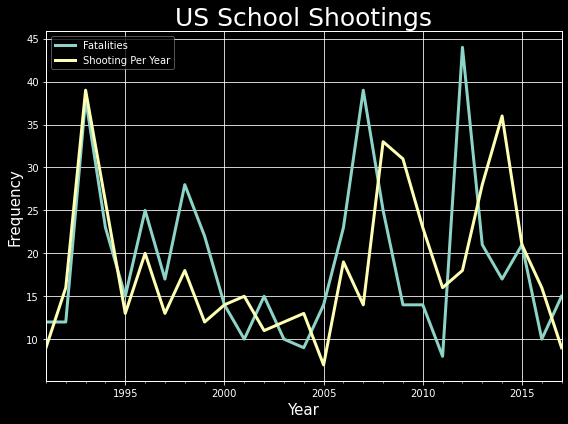

In [290]:
laws_and_shootings['Fatalities'].plot(figsize = (8, 6), linewidth = 3)
laws_and_shootings['Shooting Per Year'].plot(figsize = (8, 6), linewidth = 3)

plt.title('US School Shootings', fontsize = 25)
plt.ylabel('Frequency', fontsize = 15)
plt.xlabel('Year', fontsize = 15)
plt.legend()
plt.tight_layout();

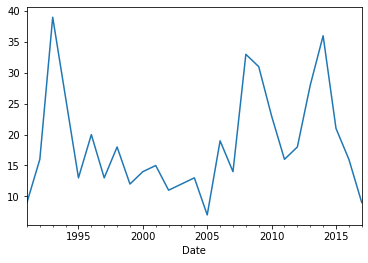

In [160]:
laws_and_shootings['Shooting Per Year'].plot();

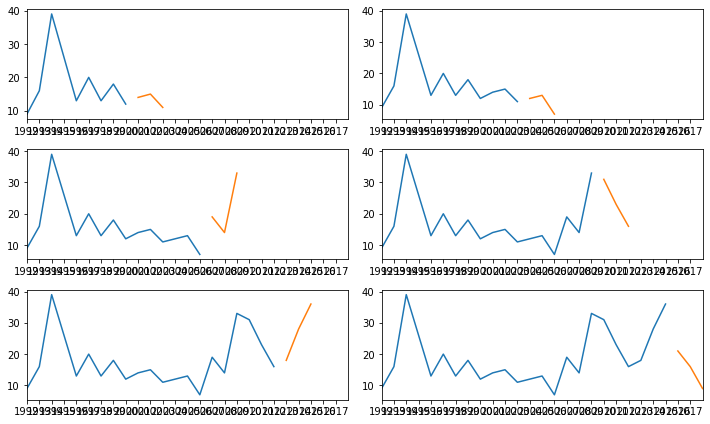

In [161]:
ts_split = TimeSeriesSplit(6)

fig,ax = plt.subplots(3, 2, figsize = (10,6))
years = mdates.YearLocator()
years_graph = mdates.DateFormatter('%Y')


for idx, (train_idx, test_idx) in enumerate(ts_split.split(laws_and_shootings)):
    ax[idx//2,idx%2].plot(laws_and_shootings.iloc[train_idx]['Shooting Per Year'])
    ax[idx//2,idx%2].plot(laws_and_shootings.iloc[test_idx]['Shooting Per Year'])
    ax[idx//2,idx%2].xaxis.set_major_locator(years)
    ax[idx//2,idx%2].xaxis.set_major_formatter(years_graph)
    ax[idx//2,idx%2].set_xlim(laws_and_shootings.index.min(), laws_and_shootings.index.max())

#plt.xticks(range(len(laws_and_shootings.index)),list(laws_and_shootings.index))
#plt.xlabel('Years', fontsize = 12)
#plt.ylabel('Count', fontsize = 12)
plt.tight_layout();

In [162]:
laws_and_shootings.head()

,Fatalities,Wounded,Shooting Per Year,age18longgunpossess,age18longgunsale,age21handgunpossess,age21handgunsale,age21longgunpossess,age21longgunsale,age21longgunsaled,...,universal,universalh,universalpermit,universalpermith,violent,violenth,violentpartial,waiting,waitingh,lawtotal
Date,,,,,,,,,,,,,,,,,,,,,
1991-12-31,12,1.0,9,3,14,3,10,0,0,0,...,2,2,5,9,3,3,10,4,11,863
1992-12-31,12,29.0,16,3,15,3,10,0,0,0,...,2,2,5,9,3,3,10,4,11,896
1993-12-31,38,5.0,39,4,15,3,10,0,0,0,...,2,2,5,9,3,3,10,4,11,923
1994-12-31,23,8.0,26,8,16,5,10,0,1,1,...,2,3,5,11,3,3,11,4,11,1021
1995-12-31,15,4.0,13,9,16,5,10,0,1,1,...,2,3,5,12,3,3,12,4,11,1035


In [163]:
yearandshootings = pd.DataFrame()

yearandlaws = pd.DataFrame()

In [164]:
count = list(laws_and_shootings['Shooting Per Year'])
lawcount = list(laws_and_shootings['lawtotal'])

In [165]:
yearandshootings['ds'] = pd.to_datetime(laws_and_shootings.index, format = "%Y")
yearandshootings['y'] = count

yearandlaws['ds'] = pd.to_datetime(laws_and_shootings.index, format = "%Y")
yearandlaws['y'] = lawcount

yearandshootings.head(), yearandlaws.head()

(          ds   y
 0 1991-12-31   9
 1 1992-12-31  16
 2 1993-12-31  39
 3 1994-12-31  26
 4 1995-12-31  13,
           ds     y
 0 1991-12-31   863
 1 1992-12-31   896
 2 1993-12-31   923
 3 1994-12-31  1021
 4 1995-12-31  1035)

In [166]:
model = Prophet()
model.fit(yearandshootings)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 20.


In [167]:
lawmodel = Prophet()
lawmodel.fit(yearandlaws)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 20.


In [168]:
future = model.make_future_dataframe(periods=5, freq = 'Y')
future.tail()

,ds
27,2018-12-31
28,2019-12-31
29,2020-12-31
30,2021-12-31
31,2022-12-31


In [169]:
lawfuture = lawmodel.make_future_dataframe(periods=5, freq = 'Y')
lawfuture.tail()

,ds
27,2018-12-31
28,2019-12-31
29,2020-12-31
30,2021-12-31
31,2022-12-31


In [170]:
forecast = model.predict(future)

lawforecast = lawmodel.predict(lawfuture)
#forecast

In [171]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
27,2018-12-31,20.218767,10.347456,30.919134
28,2019-12-31,18.881639,9.122306,29.552716
29,2020-12-31,22.672708,12.348910,33.254908
30,2021-12-31,21.881739,11.315006,33.127244
31,2022-12-31,20.816959,10.349427,30.717231


In [172]:
lawforecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
27,2018-12-31,1396.557750,1380.013998,1412.705856
28,2019-12-31,1413.916450,1396.120928,1431.249518
29,2020-12-31,1427.498878,1408.071283,1447.316034
30,2021-12-31,1454.680372,1432.884957,1476.236896
31,2022-12-31,1476.970167,1450.378824,1502.734254


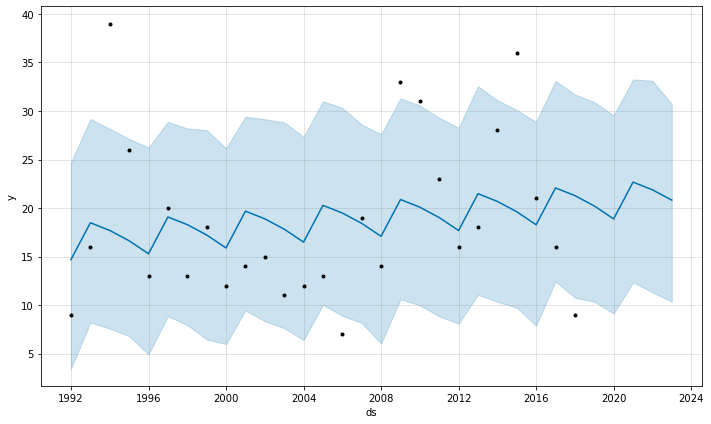

In [173]:
fig1 = model.plot(forecast)

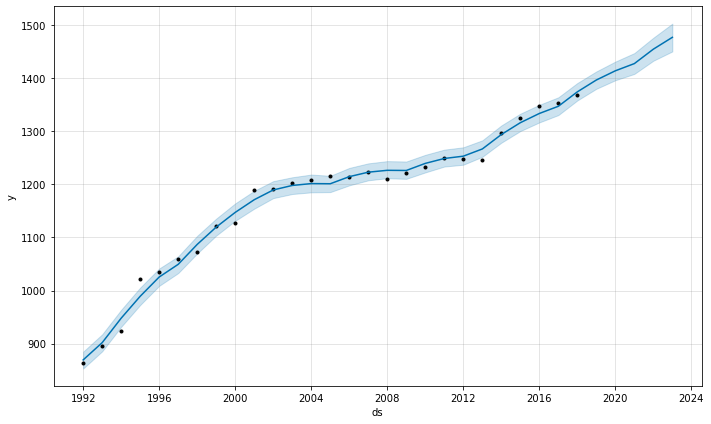

In [174]:
fig2 = lawmodel.plot(lawforecast)

In [ ]:
forecast['trend'].plot();

In [ ]:
updated_shooting.groupby(pd.Grouper(freq='Y')).sum()


In [ ]:
lat = []
lon = []        

In [ ]:
place = updated_shooting['City'] + ' ' + updated_shooting['State']
place = list(place)

In [ ]:
#place

In [ ]:
updated_shooting.shape

In [ ]:
geolocator = Nominatim(user_agent = 'tor_explorer')

for elem in place:
    loc = geolocator.geocode(elem)
        #print(loc.raw['lat'], loc.raw['lon'])
    try:
        lat.append(loc.latitude)
        lon.append(loc.longitude)
            
    except:
        print(elem)
        
#Realized this was not working because four of the cities are mispelled. 
#They should be Carrollton, Grundy, Noblesville, Bloutsville.



In [ ]:
#print(lat, lon)

In [ ]:
len(lat), len(lon)

In [ ]:
updated_shooting['Latitude'] = lat
updated_shooting['Longitude'] = lon

In [ ]:
updated_shooting.head()

In [ ]:
locat = geoloc.geocode('Brooklyn New York')
print(locat.latitude, locat.longitude)

In [ ]:
fig = go.Figure(data=go.Scattergeo(
        lon = updated_shooting['Longitude'],
        lat = updated_shooting['Latitude'],
        text = updated_shooting['City'],
        mode = 'markers',
        marker_color = updated_shooting['Fatalities']+ updated_shooting['Wounded'],
        opacity = 0.5,
        showlegend = True))

fig.update_layout(title = 'US School Shootings by City',
        geo_scope='usa')

fig.show()

plt.savefig('US School Shootings by City')

In [ ]:
state_guns['# of guns per capita'].max()

In [ ]:
state_guns.tail()

In [ ]:
#!pip install mpl-tools

In [ ]:
state_lst = list(state_guns['State'])
abbreviations = []

In [ ]:
state_lst[1]

In [ ]:
state_lst[1] = 'District of Columbia'
state_lst[1]

In [ ]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

In [ ]:
for elem in state_lst:
    for key, val in us_state_abbrev.items():
        if elem == key:
            abbreviations.append(val)

In [ ]:
len(abbreviations)

In [ ]:
state_guns.insert(loc = 1, column = 'State_Abreviation',value = abbreviations)

In [ ]:
state_guns.head()

In [ ]:
st_abrev = state_guns['State_Abreviation'].tolist()

In [ ]:
fig = px.choropleth(data_frame = state_guns, locations = st_abrev, locationmode = 'USA-states', 
                    color = '# of guns registered', scope = 'usa', title = 'Registered Guns Per State', hover_name = 'State_Abreviation')
fig.show()

# Regression Model

In [291]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
import datetime


In [ ]:
updated_shooting.groupby(['State']).sum()

In [ ]:
gun_laws.head()

In [ ]:
combined_data = gun_laws

In [ ]:
combined_data['Number of School Shootings'] = 

In [ ]:
updated_shooting.info()

In [ ]:
shooting_df.info()

In [253]:
final_merged_year_state.columns.get_loc('lawtotal')

134

In [246]:
X = final_merged_year_state.iloc[:, : -1]
y = final_merged_year_state['Number of Shootings']

In [247]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [250]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train,y_train)
y_pred = rf_model.predict(X_test)
mean_squared_error(y_test, y_pred)

0.21754037037037038

In [294]:
r2_score(y_test, y_pred)

0.6697756746626686

In [261]:
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
lin_y_pred = lin_model.predict(X_test)
mean_squared_error(y_test, lin_y_pred)

0.8099737370729214

In [263]:
log_model = LogisticRegression()
log_model.fit(X_train, y_train)
log_y_pred = log_model.predict(X_test)
mean_squared_error(y_test, log_y_pred)

/Users/laurenmarshall/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.7296296296296296

In [256]:
X2 = final_merged_year_state.drop(columns = 'lawtotal', axis = 1)
y2 = final_merged_year_state['lawtotal']

In [257]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size = 0.2, random_state = 42)

In [258]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train2,y_train2)
y_pred2 = rf_model.predict(X_test2)
mean_squared_error(y_test2, y_pred2)

0.45731370370370333

In [264]:
lin2_model = LinearRegression()
lin2_model.fit(X_train2,y_train2)
lin2_y_pred = lin2_model.predict(X_test2)
mean_squared_error(y_test2, lin2_y_pred)

3.820779455709922e-25

In [295]:
r2_score(y_test2, y_pred2)

0.9991716059372926

## NLP and LDA

In [ ]:
import nltk
from nltk.corpus import stopwords
from sklearn.decomposition import LatentDirichletAllocation
#nltk.download('stopwords')
from collections import Counter
import re

In [ ]:
updated_shooting['Desc'][0]

In [ ]:
descriptions_df = updated_shooting.iloc[:,9]
descriptions = descriptions_df[descriptions_df.notnull()]
descriptions_lst = list(descriptions)
descriptions_lst

In [ ]:
str_descriptions = ' '.join(descriptions_lst)
str_descriptions = str_descriptions.replace('¬†', ' ')
str_descriptions

In [ ]:
Counter(str_descriptions.split()).most_common()

In [ ]:
#stopwords.words('english')

In [ ]:
lower_desc = str_descriptions.lower()
no_punc_desc = re.findall('[A-Za-z0-9]+', lower_desc)
filtered_descriptions = [w for w in no_punc_desc if w not in stopwords.words('english')]
Counter(filtered_descriptions).most_common()